In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("C:/Users/nkkha/Downloads/Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.columns = ['Date','Production']
df.head()

,Date,Production
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [5]:
df.set_index('Date',inplace=True)
df.head()

,Production
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<AxesSubplot:xlabel='Date'>

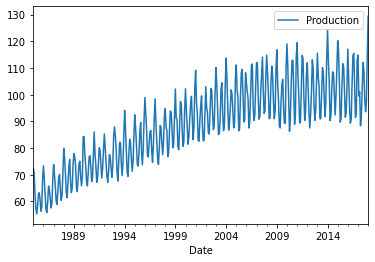

In [6]:
df.plot()

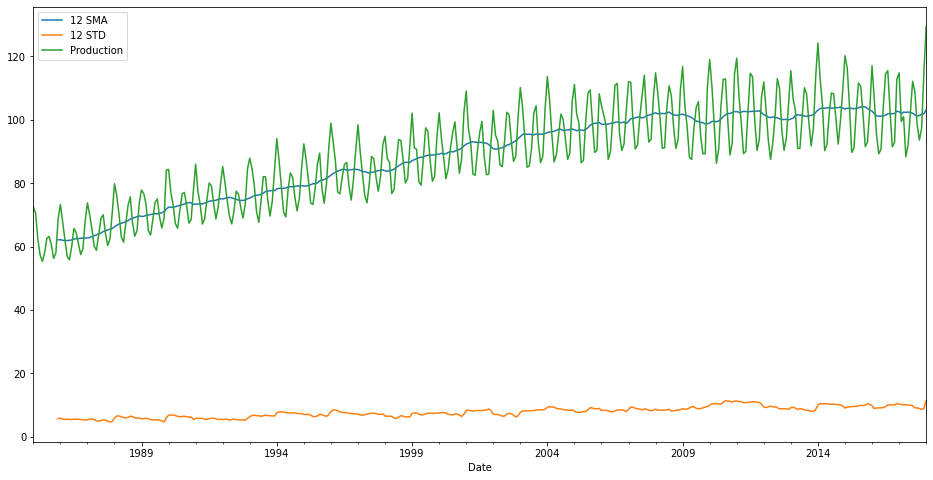

In [7]:
df['Production'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
df['Production'].rolling(12).std().plot(label='12 STD')
df['Production'].plot()
plt.legend()

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

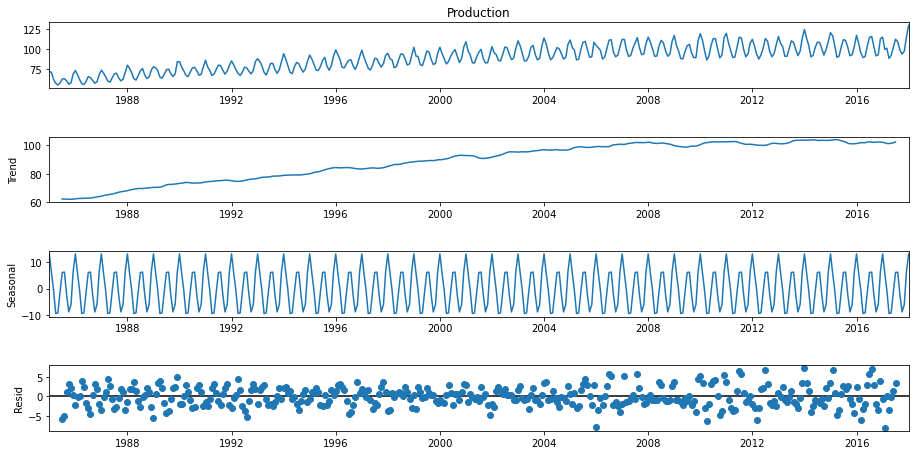

In [9]:
decomp = seasonal_decompose(df['Production'])
fig = decomp.plot()
fig.set_size_inches(14,7)

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
fuller_test = adfuller(df['Production'])
fuller_test

(-2.2569903500472455,
 0.18621469116586759,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

In [12]:
def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

In [13]:
test_p_value(df['Production'])

P-value:  0.18621469116586759
Do not reject null hypothesis, data is not stationary


<AxesSubplot:xlabel='Date'>

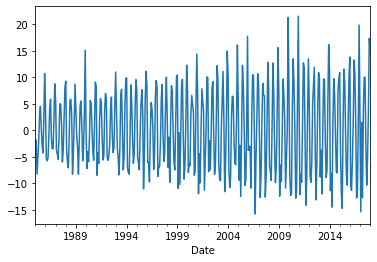

In [14]:
df['First_diff'] = df['Production'] - df['Production'].shift(1)
df['First_diff'].plot()

In [15]:
test_p_value(df['First_diff'].dropna())

P-value:  4.077786565538474e-10
Reject null hypothesis, data is stationary


<AxesSubplot:xlabel='Date'>

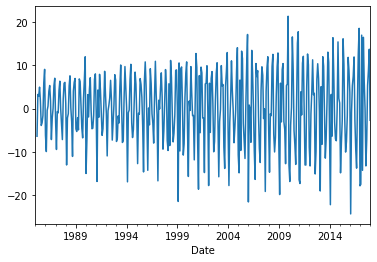

In [16]:
df['Second_diff'] = df['First_diff'] - df['First_diff'].shift(1)
df['Second_diff'].plot()

In [17]:
test_p_value(df['Second_diff'].dropna())

P-value:  4.1836937479957573e-17
Reject null hypothesis, data is stationary


<AxesSubplot:xlabel='Date'>

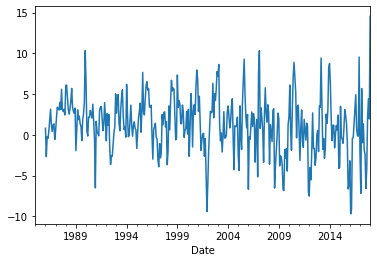

In [18]:
df['Seasonal_diff'] = df['Production'] - df['Production'].shift(12)
df['Seasonal_diff'].plot()

In [19]:
test_p_value(df['Seasonal_diff'].dropna())

P-value:  8.812644938088811e-07
Reject null hypothesis, data is stationary


In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

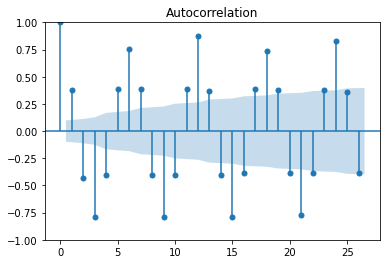

In [21]:
first_diff = plot_acf(df['First_diff'].dropna())

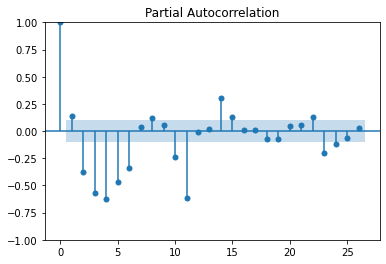

In [22]:
sec_diff = plot_pacf(df['Second_diff'].dropna())

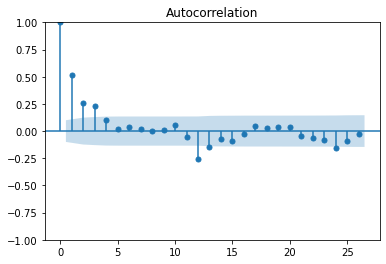

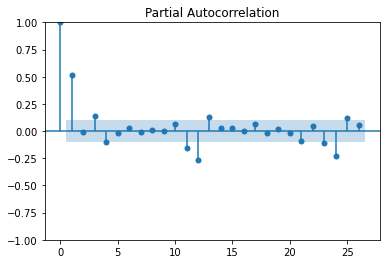

In [23]:
p1 = plot_acf(df['Seasonal_diff'].dropna())
p2 = plot_pacf(df['Seasonal_diff'].dropna())


In [24]:
from statsmodels.tsa.arima_model import ARIMA

In [25]:
model = sm.tsa.statespace.SARIMAX(df['Production'],order=(0,1,0),seasonal_order=(1,1,1,12))

In [26]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  397
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -928.856
Date:                              Tue, 19 Jul 2022   AIC                           1863.712
Time:                                      21:19:11   BIC                           1875.564
Sample:                                  01-01-1985   HQIC                          1868.413
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0421      0.058      0.721      0.471      -0.072       0.157
ma.S.L12      -0.7790      0.041    -19.119      0.000      -0.859      -0.699
sigma2         7.1906      0.417     17.245      0.000       6.373       8.008
===================================================================================
Ljung-Box (L1) (Q):                  13.53   Jarque-Bera (JB):                30.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
results.resid

Date
1985-01-01    72.505200
1985-02-01    -1.833200
1985-03-01    -8.221800
1985-04-01    -4.978800
1985-05-01    -2.156300
                ...    
2017-09-01     0.529985
2017-10-01     4.057874
2017-11-01     0.690663
2017-12-01     2.477697
2018-01-01     6.953533
Length: 397, dtype: float64

<AxesSubplot:xlabel='Date'>

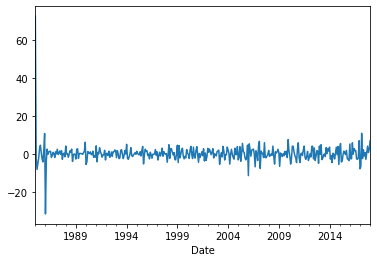

In [28]:
results.resid.plot()

<AxesSubplot:ylabel='Density'>

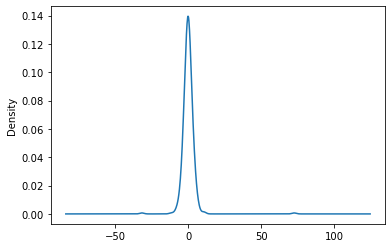

In [29]:
results.resid.plot(kind='kde')

<AxesSubplot:xlabel='Date'>

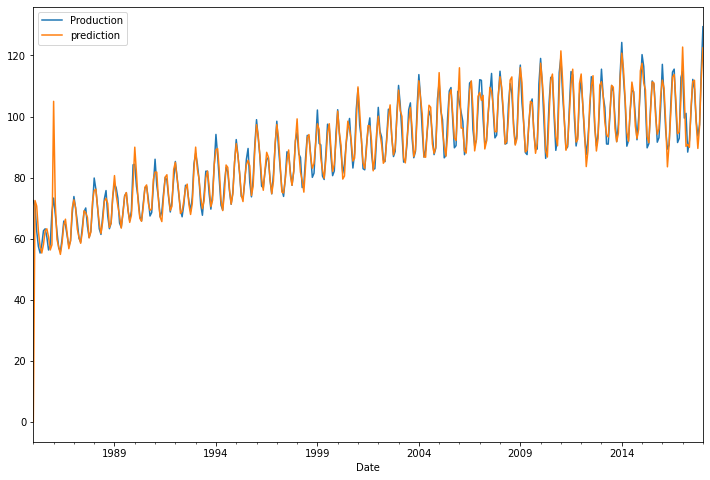

In [30]:
df['prediction'] = results.predict()
df[['Production','prediction']].plot(figsize=(12,8))

In [31]:
from pandas.tseries.offsets import DateOffset
extra_dates = [df.index[-1] + DateOffset(months=m) for m in range (1,24)]

In [32]:
extra_dates

[Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

In [33]:
forecast_df = pd.DataFrame(index=extra_dates,columns=df.columns)
forecast_df.head()

,Production,First_diff,Second_diff,Seasonal_diff,prediction
2018-02-01,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN
2018-06-01,NaN,NaN,NaN,NaN,NaN


In [34]:
final_df = pd.concat([df,forecast_df])

<AxesSubplot:>

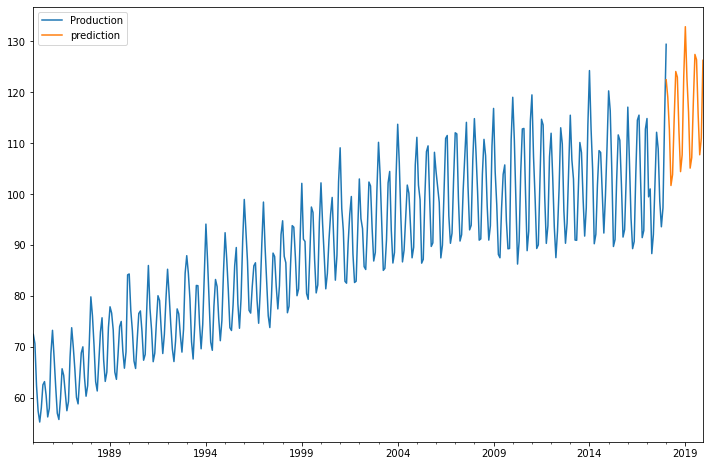

In [35]:
final_df['prediction'] = results.predict(start=396, end=430)
final_df[['Production','prediction']].plot(figsize=(12,8))